In [2]:
from transformers import BertTokenizer, BertModel, BertForMaskedLM

import torch
from transformers import AutoTokenizer, AutoModel
#from keras.preprocessing.sequence import pad_sequences
from keras_preprocessing.sequence import pad_sequences

In [58]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 

In [3]:
from transformers import RobertaTokenizer, RobertaConfig, RobertaForSequenceClassification

In [4]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split 

In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer,WordNetLemmatizer
from nltk.tokenize import word_tokenize
import gensim
from wordcloud import WordCloud, STOPWORDS

from collections import defaultdict, Counter
import string
from sklearn.feature_extraction.text import CountVectorizer
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [64]:
df = pd.read_csv("train.csv", sep='\t')
df = df[df['label']!='label']
df['label'] = df['label'].astype('int32')

In [65]:
X = df['text']
y = df['label']

In [66]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4986 entries, 0 to 4986
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    4986 non-null   object
 1   label   4986 non-null   int32 
dtypes: int32(1), object(1)
memory usage: 97.4+ KB


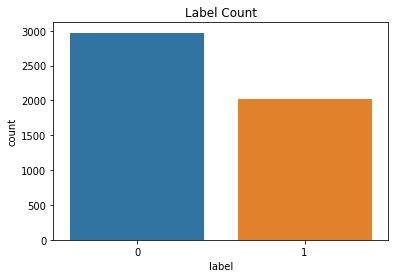

In [68]:
#train_data['label'].hist()
sns.countplot(x = df['label'],data = df)
plt.title('Label Count')
plt.show()

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size= 0.2)

In [72]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)
y_train = pd.DataFrame(y_train)
y_test = pd.DataFrame(y_test)

# BERT

In [74]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)


encoded_data_train = tokenizer.batch_encode_plus(X_train.text.values,add_special_tokens=True,return_attention_mask=True,
    pad_to_max_length=True,max_length=512,return_tensors='pt')


encoded_data_val = tokenizer.batch_encode_plus(X_test.text.values, add_special_tokens=True,
    return_attention_mask=True, pad_to_max_length=True, max_length=512, return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [75]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.label.values, dtype = torch.long)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_test.label.values, dtype = torch.long)

dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val, labels_val)

In [76]:
from transformers import BertForSequenceClassification

In [77]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [78]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

In [79]:
batch_size = 4 #32

dataloader_train= DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val= DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

In [80]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 10
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs)

In [81]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [82]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [83]:
from tqdm import tqdm

In [84]:
import random
from tqdm import tqdm
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids'      : batch[0],
            'attention_mask'  : batch[1],
            'labels'          : batch[2]
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({
            'training_loss': '{:.3f}'.format(loss.item()/len(batch))
        })
        
    torch.save(model.state_dict(), f'BERT_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Val loss: {val_loss}')
    tqdm.write(f'f1 score: {val_f1}')

Epoch 1:   0%|          | 1/997 [00:00<02:48,  5.90it/s, training_loss=0.252]

cuda



Epoch 1:   2%|▏         | 15/997 [00:02<02:29,  6.56it/s, training_loss=0.307]

  0%|          | 0/10 [00:02<?, ?it/s]                                        


KeyboardInterrupt: 

In [ ]:
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()

In [ ]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, precision_score, f1_score, classification_report
print(accuracy_score(preds_flat, labels_flat))
print(recall_score(preds_flat, labels_flat))
print(roc_auc_score(preds_flat, labels_flat))
print(precision_score(preds_flat, labels_flat))
print(f1_score(preds_flat, labels_flat))

# Roberta

In [20]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', do_lower_case=True)


encoded_data_train = tokenizer.batch_encode_plus(X_train.text.values,add_special_tokens=True,return_attention_mask=True,
    pad_to_max_length=True,max_length=256,return_tensors='pt')


encoded_data_test = tokenizer.batch_encode_plus(X_test.text.values, add_special_tokens=True,
    return_attention_mask=True, pad_to_max_length=True, max_length=256, return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/home/re6101045/.local/lib/python3.6/site-packages/transformers/tokenization_utils_base.py:2269: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


In [21]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.label.values, dtype = torch.long)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_test.label.values, dtype = torch.long)

dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val, labels_val)

In [22]:
model = RobertaForSequenceClassification.from_pretrained(
    'roberta-base',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifie

In [23]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

In [24]:
batch_size = 4 #32

dataloader_train= DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val= DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

In [25]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs)

/home/re6101045/.local/lib/python3.6/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [26]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [27]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [28]:
import random
from tqdm import tqdm
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids'      : batch[0],
            'attention_mask'  : batch[1],
            'labels'          : batch[2]
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({
            'training_loss': '{:.3f}'.format(loss.item()/len(batch))
        })
        
    torch.save(model.state_dict(), f'Roberta_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Val loss: {val_loss}')
    tqdm.write(f'f1 score: {val_f1}')

Epoch 1:   0%|          | 1/997 [00:00<01:42,  9.69it/s, training_loss=0.223]

cuda



Epoch 1:  13%|█▎        | 133/997 [00:11<01:13, 11.69it/s, training_loss=0.236]


Epoch 1:  26%|██▋       | 263/997 [00:22<01:04, 11.31it/s, training_loss=0.068]


Epoch 1:  40%|███▉      | 395/997 [00:34<00:52, 11.39it/s, training_loss=0.258]


Epoch 1:  53%|█████▎    | 525/997 [00:45<00:41, 11.25it/s, training_loss=0.240]


Epoch 1:  66%|██████▌   | 655/997 [00:57<00:30, 11.06it/s, training_loss=0.223]


Epoch 1:  78%|███████▊  | 780/997 [01:09<00:21, 10.06it/s, training_loss=0.038]


Epoch 1:  89%|████████▉ | 891/997 [01:21<00:13,  7.98it/s, training_loss=0.012]


Epoch 1:  99%|█████████▉| 991/997 [01:32<00:00,  9.37it/s, training_loss=0.057]


  0%|          | 0/5 [01:34<?, ?it/s]                                          


Epoch {epoch}
Training loss: 0.5887036724044095


Epoch 2:   0%|          | 1/997 [00:00<02:02,  8.13it/s, training_loss=0.180]

Val loss: 0.49663382675498724
f1 score: 0.7947111840260832



Epoch 2:  10%|█         | 102/997 [00:12<01:46,  8.44it/s, training_loss=0.065]


Epoch 2:  21%|██        | 206/997 [00:24<02:00,  6.54it/s, training_loss=0.051]


Epoch 2:  31%|███       | 311/997 [00:37<01:15,  9.09it/s, training_loss=0.009]


Epoch 2:  41%|████▏     | 413/997 [00:51<02:01,  4.79it/s, training_loss=0.262]


Epoch 2:  52%|█████▏    | 517/997 [01:05<01:18,  6.10it/s, training_loss=0.922]


Epoch 2:  63%|██████▎   | 624/997 [01:19<00:54,  6.83it/s, training_loss=0.065]


Epoch 2:  72%|███████▏  | 722/997 [01:33<00:38,  7.19it/s, training_loss=0.361]


Epoch 2:  83%|████████▎ | 823/997 [01:47<00:28,  6.09it/s, training_loss=0.323]


Epoch 2:  93%|█████████▎| 924/997 [02:00<00:10,  7.00it/s, training_loss=0.007]


 20%|██        | 1/5 [03:54<06:47, 101.80s/it]                                 


Epoch {epoch}
Training loss: 0.5234925736404148


Epoch 3:   0%|          | 1/997 [00:00<02:29,  6.67it/s, training_loss=0.149]

Val loss: 0.6558556570671499
f1 score: 0.8226177733640363



Epoch 3:  10%|█         | 103/997 [00:13<02:07,  7.03it/s, training_loss=0.008]


Epoch 3:  20%|██        | 203/997 [00:27<01:31,  8.63it/s, training_loss=0.435]


Epoch 3:  31%|███       | 306/997 [00:41<01:41,  6.80it/s, training_loss=0.447]


Epoch 3:  41%|████      | 407/997 [00:54<00:58, 10.16it/s, training_loss=0.382]


Epoch 3:  51%|█████     | 506/997 [01:10<01:09,  7.11it/s, training_loss=0.442]


Epoch 3:  61%|██████    | 604/997 [01:23<00:45,  8.59it/s, training_loss=0.125]


Epoch 3:  71%|███████   | 703/997 [01:37<00:35,  8.39it/s, training_loss=0.273]


Epoch 3:  80%|████████  | 802/997 [01:51<00:27,  7.10it/s, training_loss=0.407]


Epoch 3:  90%|█████████ | 902/997 [02:05<00:13,  7.17it/s, training_loss=0.390]


 40%|████      | 2/5 [06:22<05:40, 113.57s/it]                                 


Epoch {epoch}
Training loss: 0.4627590912283065


Epoch 4:   0%|          | 1/997 [00:00<02:41,  6.17it/s, training_loss=0.002]

Val loss: 0.794062151806429
f1 score: 0.8117734564400179



Epoch 4:  10%|█         | 103/997 [00:14<01:53,  7.85it/s, training_loss=0.293]


Epoch 4:  21%|██        | 206/997 [00:28<02:12,  5.98it/s, training_loss=0.440]


Epoch 4:  31%|███       | 305/997 [00:42<02:07,  5.41it/s, training_loss=0.001]


Epoch 4:  40%|████      | 403/997 [00:55<01:47,  5.53it/s, training_loss=0.001]


Epoch 4:  50%|█████     | 501/997 [01:09<01:09,  7.10it/s, training_loss=0.002]


Epoch 4:  60%|██████    | 602/997 [01:23<00:58,  6.70it/s, training_loss=0.001]


Epoch 4:  70%|███████   | 700/997 [01:37<00:42,  7.07it/s, training_loss=0.001]


Epoch 4:  80%|████████  | 798/997 [01:51<00:28,  7.05it/s, training_loss=0.025]


Epoch 4:  90%|█████████ | 899/997 [02:05<00:09,  9.86it/s, training_loss=0.001]


 60%|██████    | 3/5 [08:53<04:08, 124.37s/it]                                 


Epoch {epoch}
Training loss: 0.37558143784900627


Epoch 5:   0%|          | 1/997 [00:00<02:18,  7.19it/s, training_loss=0.001]

Val loss: 0.8988251108676195
f1 score: 0.8185664568279414



Epoch 5:  10%|█         | 100/997 [00:13<02:06,  7.06it/s, training_loss=0.069]


Epoch 5:  20%|██        | 201/997 [00:27<01:52,  7.10it/s, training_loss=0.305]


Epoch 5:  30%|███       | 300/997 [00:42<01:37,  7.14it/s, training_loss=0.001]


Epoch 5:  40%|███▉      | 398/997 [00:56<01:24,  7.13it/s, training_loss=0.681]


Epoch 5:  50%|████▉     | 496/997 [01:09<01:10,  7.12it/s, training_loss=0.001]


Epoch 5:  60%|█████▉    | 598/997 [01:22<00:45,  8.72it/s, training_loss=0.003]


Epoch 5:  70%|███████   | 699/997 [01:37<00:49,  5.97it/s, training_loss=0.506]


Epoch 5:  80%|███████▉  | 797/997 [01:51<00:28,  7.13it/s, training_loss=0.001]


Epoch 5:  90%|████████▉ | 895/997 [02:05<00:14,  7.16it/s, training_loss=0.000]


Epoch 5: 100%|█████████▉| 995/997 [02:19<00:00,  7.76it/s, training_loss=0.000]


 80%|████████  | 4/5 [11:23<02:12, 132.10s/it]                                 


Epoch {epoch}
Training loss: 0.2803527077762368


100%|██████████| 5/5 [11:32<00:00, 138.57s/it]

Val loss: 0.9225723288545851
f1 score: 0.821318642290121


In [29]:
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()

In [30]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
print(accuracy_score(preds_flat, labels_flat))
print(recall_score(preds_flat, labels_flat))
print(roc_auc_score(preds_flat, labels_flat))
print(precision_score(preds_flat, labels_flat))
print(f1_score(preds_flat, labels_flat))

0.8216432865731463
0.7803617571059431
0.8140761322354593
0.7645569620253164
0.7723785166240409


In [21]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
print(accuracy_score(preds_flat, labels_flat))
print(recall_score(preds_flat, labels_flat))
print(roc_auc_score(preds_flat, labels_flat))
print(precision_score(preds_flat, labels_flat))
print(f1_score(preds_flat, labels_flat))

0.7995991983967936
0.7406417112299465
0.787788804332922
0.7289473684210527
0.7347480106100797


# XLNet

In [48]:
from transformers import XLNetTokenizer, XLNetConfig, XLNetForSequenceClassification
import sentencepiece

In [49]:
tokenizer = XLNetTokenizer.from_pretrained('xlnet-base-cased')


encoded_data_train = tokenizer.batch_encode_plus(X_train.text.values,add_special_tokens=True,return_attention_mask=True,
    pad_to_max_length=True,max_length=256,return_tensors='pt')


encoded_data_val = tokenizer.batch_encode_plus(X_test.text.values, add_special_tokens=True,
    return_attention_mask=True, pad_to_max_length=True, max_length=256, return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [20]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.label.values, dtype = torch.long)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_test.label.values, dtype = torch.long)

dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val, labels_val)

In [21]:
model = XLNetForSequenceClassification.from_pretrained(
    'xlnet-base-cased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False)

Some weights of the model checkpoint at xlnet-base-cased were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'sequence_summary.summary.weight', 'logits_proj.weight', 'sequence_summary.summary.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions a

In [22]:
from torch.utils.data import Dataset, DataLoader, RandomSampler

In [23]:
batch_size = 4 #32

dataloader_train= DataLoader(
    dataset_train,
    sampler=RandomSampler(dataset_train),
    batch_size=batch_size
)

dataloader_val= DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32
)

In [27]:
from transformers import AdamW, get_linear_schedule_with_warmup

optimizer = AdamW(
    model.parameters(),
    lr=1e-5,
    eps=1e-8
)

epochs = 5
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=len(dataloader_train)*epochs)

In [28]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score
def f1_score_func(preds, labels):
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    return f1_score(labels_flat, preds_flat, average='weighted')

def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in label_dict.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy: {len(y_preds[y_preds==label])}/{len(y_true)}\n')

In [29]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [30]:
import random
from tqdm import tqdm
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids'      : batch[0],
            'attention_mask'  : batch[1],
            'labels'          : batch[2]
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({
            'training_loss': '{:.3f}'.format(loss.item()/len(batch))
        })
        
    #torch.save(model.state_dict(), f'Roberta_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Val loss: {val_loss}')
    tqdm.write(f'f1 score: {val_f1}')

Epoch 1:   0%|          | 0/997 [00:00<?, ?it/s]

cuda



Epoch 1:  10%|▉         | 99/997 [00:27<04:07,  3.63it/s, training_loss=0.224]


Epoch 1:  20%|█▉        | 197/997 [00:57<03:58,  3.36it/s, training_loss=0.148]


Epoch 1:  30%|██▉       | 295/997 [01:28<03:42,  3.15it/s, training_loss=0.409]


Epoch 1:  39%|███▉      | 393/997 [02:00<03:13,  3.12it/s, training_loss=0.180]


Epoch 1:  49%|████▉     | 491/997 [02:32<02:43,  3.10it/s, training_loss=0.161]


Epoch 1:  59%|█████▉    | 589/997 [03:06<02:08,  3.17it/s, training_loss=0.236]


Epoch 1:  69%|██████▉   | 687/997 [03:38<01:40,  3.10it/s, training_loss=0.425]


Epoch 1:  79%|███████▊  | 785/997 [04:12<01:09,  3.06it/s, training_loss=0.358]


Epoch 1:  89%|████████▊ | 883/997 [04:46<00:35,  3.23it/s, training_loss=0.064]


Epoch 1:  98%|█████████▊| 981/997 [05:18<00:05,  2.91it/s, training_loss=0.131]


  0%|          | 0/5 [05:23<?, ?it/s]                                          


Epoch {epoch}
Training loss: 0.6030744519271517


Epoch 2:   0%|          | 0/997 [00:00<?, ?it/s]

Val loss: 0.7284250287339091
f1 score: 0.6047392293994504



Epoch 2:  10%|▉         | 99/997 [00:32<04:42,  3.17it/s, training_loss=0.012]


Epoch 2:  20%|█▉        | 197/997 [01:05<04:17,  3.11it/s, training_loss=0.040]


Epoch 2:  30%|██▉       | 295/997 [01:38<05:49,  2.01it/s, training_loss=0.856]


Epoch 2:  39%|███▉      | 393/997 [02:11<03:06,  3.24it/s, training_loss=0.610]


Epoch 2:  49%|████▉     | 491/997 [02:44<02:39,  3.18it/s, training_loss=0.161]


Epoch 2:  59%|█████▉    | 589/997 [03:18<02:38,  2.58it/s, training_loss=0.385]


Epoch 2:  69%|██████▉   | 687/997 [03:50<01:45,  2.93it/s, training_loss=0.668]


Epoch 2:  79%|███████▊  | 785/997 [04:22<01:11,  2.98it/s, training_loss=0.224]


Epoch 2:  89%|████████▊ | 883/997 [04:55<00:37,  3.05it/s, training_loss=0.177]


Epoch 2:  98%|█████████▊| 981/997 [05:27<00:05,  3.03it/s, training_loss=0.547]


 20%|██        | 1/5 [11:38<24:23, 365.82s/it]                                 


Epoch {epoch}
Training loss: 0.5328023171172839


Epoch 3:   0%|          | 0/997 [00:00<?, ?it/s]

Val loss: 0.6450964058749378
f1 score: 0.797453400338265



Epoch 3:  10%|▉         | 99/997 [00:32<04:55,  3.04it/s, training_loss=0.090]


Epoch 3:  20%|█▉        | 197/997 [01:05<04:18,  3.09it/s, training_loss=0.149]


Epoch 3:  30%|██▉       | 295/997 [01:38<04:26,  2.63it/s, training_loss=0.065]


Epoch 3:  39%|███▉      | 393/997 [02:11<03:12,  3.14it/s, training_loss=0.317]


Epoch 3:  49%|████▉     | 491/997 [02:44<02:42,  3.11it/s, training_loss=0.013]


Epoch 3:  59%|█████▉    | 589/997 [03:16<02:18,  2.95it/s, training_loss=0.001]


Epoch 3:  69%|██████▉   | 687/997 [03:49<01:47,  2.88it/s, training_loss=0.605]


Epoch 3:  79%|███████▊  | 785/997 [04:23<01:16,  2.76it/s, training_loss=0.321]


Epoch 3:  89%|████████▊ | 883/997 [04:57<00:36,  3.12it/s, training_loss=0.004]


Epoch 3:  98%|█████████▊| 981/997 [05:31<00:04,  3.27it/s, training_loss=0.261]


 40%|████      | 2/5 [17:56<18:24, 368.33s/it]                                 


Epoch {epoch}
Training loss: 0.4834804092487764


Epoch 4:   0%|          | 0/997 [00:00<?, ?it/s]

Val loss: 0.7666887168597896
f1 score: 0.8121405292626713



Epoch 4:  10%|▉         | 99/997 [00:34<04:47,  3.12it/s, training_loss=0.045]


Epoch 4:  20%|█▉        | 197/997 [01:06<04:28,  2.98it/s, training_loss=0.281]


Epoch 4:  30%|██▉       | 295/997 [01:39<03:45,  3.12it/s, training_loss=0.000]


Epoch 4:  39%|███▉      | 393/997 [02:12<06:06,  1.65it/s, training_loss=0.004]


Epoch 4:  49%|████▉     | 491/997 [02:45<02:43,  3.10it/s, training_loss=0.014]


Epoch 4:  59%|█████▉    | 589/997 [03:18<02:21,  2.88it/s, training_loss=0.024]


Epoch 4:  69%|██████▉   | 687/997 [03:50<01:38,  3.16it/s, training_loss=0.161]


Epoch 4:  79%|███████▊  | 785/997 [04:23<01:10,  3.03it/s, training_loss=0.136]


 60%|██████    | 3/5 [23:10<15:26, 463.44s/it]                                 


KeyboardInterrupt: 

In [18]:
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()

# embedding_size = 512

In [19]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
print(accuracy_score(preds_flat, labels_flat))
print(recall_score(preds_flat, labels_flat))
print(roc_auc_score(preds_flat, labels_flat))
print(precision_score(preds_flat, labels_flat))
print(f1_score(preds_flat, labels_flat))

0.8046092184368737
0.7745358090185677
0.7987010768120214
0.7263681592039801
0.7496790757381259


# Longformer

In [50]:
from transformers import LongformerConfig, LongformerModel, LongformerTokenizer, LongformerForSequenceClassification

In [51]:
tokenizer = LongformerTokenizer.from_pretrained('allenai/longformer-base-4096')

encoded_data_train = tokenizer.batch_encode_plus(X_train.text.values,add_special_tokens=True,return_attention_mask=True,
    pad_to_max_length=True,max_length=512,return_tensors='pt')


encoded_data_val = tokenizer.batch_encode_plus(X_test.text.values, add_special_tokens=True,
    return_attention_mask=True, pad_to_max_length=True, max_length=512, return_tensors='pt')

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


In [52]:
input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']
labels_train = torch.tensor(y_train.label.values, dtype = torch.long)

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']
labels_val = torch.tensor(y_test.label.values, dtype = torch.long)

dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train, labels_train)
dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val, labels_val)

In [53]:
def evaluate(dataloader_val):

    model.eval()
    
    loss_val_total = 0
    predictions, true_vals = [], []
    
    for batch in dataloader_val:
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {'input_ids':      batch[0],
                  'attention_mask': batch[1],
                  'labels':         batch[2],
                 }

        with torch.no_grad():        
            outputs = model(**inputs)
            
        loss = outputs[0]
        logits = outputs[1]
        loss_val_total += loss.item()

        logits = logits.detach().cpu().numpy()
        label_ids = inputs['labels'].cpu().numpy()
        predictions.append(logits)
        true_vals.append(label_ids)
    
    loss_val_avg = loss_val_total/len(dataloader_val) 
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
            
    return loss_val_avg, predictions, true_vals

In [54]:
model = LongformerForSequenceClassification.from_pretrained(
    'allenai/longformer-base-4096',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False)

Some weights of the model checkpoint at allenai/longformer-base-4096 were not used when initializing LongformerForSequenceClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing LongformerForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of LongformerForSequenceClassification were not initialized from the model checkpoint at allenai/longformer-base-4096 and are newly initialized: ['classifier.dense.weight', 'classifier.out_proj.weigh

In [55]:
import random
from tqdm import tqdm
seed_val = 17
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

print(device)

for epoch in tqdm(range(1, epochs+1)):
    
    model.train()
    
    loss_train_total = 0
    progress_bar = tqdm(dataloader_train, 
                        desc='Epoch {:1d}'.format(epoch),
                        leave=False,
                        disable=False)
    for batch in progress_bar:
        
        model.zero_grad()
        
        batch = tuple(b.to(device) for b in batch)
        
        inputs = {
            'input_ids'      : batch[0],
            'attention_mask'  : batch[1],
            'labels'          : batch[2]
        }
        
        outputs = model(**inputs)
        
        loss = outputs[0]
        loss_train_total += loss.item()
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        
        optimizer.step()
        scheduler.step()
        
        progress_bar.set_postfix({
            'training_loss': '{:.3f}'.format(loss.item()/len(batch))
        })
        
    #torch.save(model.state_dict(), f'Roberta_ft_epoch{epoch}.model')
    
    tqdm.write('\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total/len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Val loss: {val_loss}')
    tqdm.write(f'f1 score: {val_f1}')

Epoch 1:   0%|          | 0/997 [00:00<?, ?it/s]

cuda



Epoch 1:  10%|▉         | 99/997 [00:34<05:04,  2.95it/s, training_loss=0.228]


Epoch 1:  20%|█▉        | 197/997 [01:08<04:53,  2.73it/s, training_loss=0.189]


Epoch 1:  30%|██▉       | 295/997 [01:45<04:30,  2.59it/s, training_loss=0.190]


Epoch 1:  39%|███▉      | 393/997 [02:25<04:06,  2.45it/s, training_loss=0.242]


Epoch 1:  49%|████▉     | 491/997 [03:06<03:34,  2.36it/s, training_loss=0.226]


Epoch 1:  59%|█████▉    | 589/997 [03:49<02:53,  2.35it/s, training_loss=0.232]


Epoch 1:  69%|██████▉   | 687/997 [04:31<02:12,  2.34it/s, training_loss=0.203]


Epoch 1:  79%|███████▊  | 785/997 [05:13<01:27,  2.42it/s, training_loss=0.246]


Epoch 1:  89%|████████▊ | 883/997 [05:56<00:53,  2.14it/s, training_loss=0.236]


Epoch 1:  98%|█████████▊| 981/997 [06:38<00:06,  2.43it/s, training_loss=0.222]


  0%|          | 0/5 [06:45<?, ?it/s]                                          


Epoch {epoch}
Training loss: 0.6810981601386993


Epoch 2:   0%|          | 0/997 [00:00<?, ?it/s]

Val loss: 0.6801845636218786
f1 score: 0.455137633167647



Epoch 2:  10%|▉         | 99/997 [00:44<06:33,  2.28it/s, training_loss=0.241]


Epoch 2:  20%|█▉        | 197/997 [01:27<06:10,  2.16it/s, training_loss=0.262]


Epoch 2:  30%|██▉       | 295/997 [02:10<05:28,  2.14it/s, training_loss=0.231]


Epoch 2:  39%|███▉      | 393/997 [02:53<04:23,  2.29it/s, training_loss=0.215]


Epoch 2:  49%|████▉     | 491/997 [03:36<03:39,  2.30it/s, training_loss=0.228]


Epoch 2:  59%|█████▉    | 589/997 [04:18<02:36,  2.60it/s, training_loss=0.246]


Epoch 2:  69%|██████▉   | 687/997 [05:01<02:16,  2.28it/s, training_loss=0.226]


Epoch 2:  79%|███████▊  | 785/997 [05:44<01:32,  2.30it/s, training_loss=0.215]


Epoch 2:  89%|████████▊ | 883/997 [06:27<00:46,  2.45it/s, training_loss=0.222]


Epoch 2:  98%|█████████▊| 981/997 [07:10<00:06,  2.38it/s, training_loss=0.218]


 20%|██        | 1/5 [14:34<29:08, 437.00s/it]                                 


Epoch {epoch}
Training loss: 0.6804169168324026


Epoch 3:   0%|          | 0/997 [00:00<?, ?it/s]

Val loss: 0.6783248037099838
f1 score: 0.455137633167647



Epoch 3:  10%|▉         | 99/997 [00:43<06:23,  2.34it/s, training_loss=0.249]


Epoch 3:  20%|█▉        | 197/997 [01:26<05:42,  2.34it/s, training_loss=0.194]


Epoch 3:  30%|██▉       | 295/997 [02:08<05:06,  2.29it/s, training_loss=0.206]


Epoch 3:  39%|███▉      | 393/997 [02:51<04:30,  2.23it/s, training_loss=0.252]


Epoch 3:  49%|████▉     | 491/997 [03:34<03:35,  2.35it/s, training_loss=0.198]


Epoch 3:  59%|█████▉    | 589/997 [04:17<03:00,  2.26it/s, training_loss=0.232]


Epoch 3:  69%|██████▉   | 687/997 [05:00<02:17,  2.26it/s, training_loss=0.238]


Epoch 3:  79%|███████▊  | 785/997 [05:42<01:29,  2.36it/s, training_loss=0.202]


Epoch 3:  89%|████████▊ | 883/997 [06:25<00:48,  2.35it/s, training_loss=0.225]


Epoch 3:  98%|█████████▊| 981/997 [07:07<00:06,  2.41it/s, training_loss=0.217]


 40%|████      | 2/5 [22:21<22:20, 446.90s/it]                                 


Epoch {epoch}
Training loss: 0.6806508001377255


Epoch 4:   0%|          | 0/997 [00:00<?, ?it/s]

Val loss: 0.6776514295488596
f1 score: 0.455137633167647



Epoch 4:  10%|▉         | 99/997 [00:43<06:25,  2.33it/s, training_loss=0.223]


Epoch 4:  20%|█▉        | 197/997 [01:25<06:19,  2.11it/s, training_loss=0.230]


Epoch 4:  30%|██▉       | 295/997 [02:07<05:10,  2.26it/s, training_loss=0.247]


Epoch 4:  39%|███▉      | 393/997 [02:50<04:21,  2.31it/s, training_loss=0.252]


Epoch 4:  49%|████▉     | 491/997 [03:33<03:38,  2.32it/s, training_loss=0.224]


Epoch 4:  59%|█████▉    | 589/997 [04:15<03:00,  2.26it/s, training_loss=0.234]


Epoch 4:  69%|██████▉   | 687/997 [04:59<02:14,  2.30it/s, training_loss=0.216]


Epoch 4:  79%|███████▊  | 785/997 [05:42<01:34,  2.25it/s, training_loss=0.236]


Epoch 4:  89%|████████▊ | 883/997 [06:25<00:46,  2.47it/s, training_loss=0.246]


Epoch 4:  98%|█████████▊| 981/997 [07:07<00:07,  2.17it/s, training_loss=0.266]


 60%|██████    | 3/5 [30:07<15:05, 452.70s/it]                                 


Epoch {epoch}
Training loss: 0.6818487868385544


Epoch 5:   0%|          | 0/997 [00:00<?, ?it/s]

Val loss: 0.6776305623352528
f1 score: 0.455137633167647



Epoch 5:  10%|▉         | 99/997 [00:42<06:11,  2.41it/s, training_loss=0.192]


Epoch 5:  20%|█▉        | 197/997 [01:24<05:47,  2.30it/s, training_loss=0.249]


Epoch 5:  30%|██▉       | 295/997 [02:06<04:57,  2.36it/s, training_loss=0.233]


Epoch 5:  39%|███▉      | 393/997 [02:48<04:16,  2.36it/s, training_loss=0.241]


Epoch 5:  49%|████▉     | 491/997 [03:29<03:30,  2.40it/s, training_loss=0.250]


Epoch 5:  59%|█████▉    | 589/997 [04:11<03:04,  2.21it/s, training_loss=0.237]


Epoch 5:  69%|██████▉   | 687/997 [04:53<02:09,  2.40it/s, training_loss=0.260]


Epoch 5:  79%|███████▊  | 785/997 [05:35<01:32,  2.29it/s, training_loss=0.220]


Epoch 5:  89%|████████▊ | 883/997 [06:16<00:45,  2.52it/s, training_loss=0.209]


Epoch 5:  98%|█████████▊| 981/997 [06:58<00:06,  2.41it/s, training_loss=0.233]


 80%|████████  | 4/5 [37:43<07:36, 456.48s/it]                                 


Epoch {epoch}
Training loss: 0.6794106635071688


100%|██████████| 5/5 [38:13<00:00, 458.75s/it]

Val loss: 0.6807211749255657
f1 score: 0.455137633167647


In [56]:
preds_flat = np.argmax(predictions, axis=1).flatten()
labels_flat = true_vals.flatten()

In [ ]:
#1024

In [29]:
from sklearn.metrics import f1_score, accuracy_score, recall_score, roc_auc_score, precision_score, f1_score
print(accuracy_score(preds_flat, labels_flat))
print(recall_score(preds_flat, labels_flat))
print(roc_auc_score(preds_flat, labels_flat))
print(precision_score(preds_flat, labels_flat))
print(f1_score(preds_flat, labels_flat))

0.7895791583166333
0.7588235294117647
0.7821473270159127
0.6683937823834197
0.7107438016528925
